<a href="https://colab.research.google.com/github/bbberylll/ESAA_OB/blob/main/ESAA_OB_F12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 합성곱 신경망 맛보기

## 데이터
fashion_mnist 데이터셋

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

하나의 GPU를 사용할 때의 코드

다수의 GPU를 사용한다면

if torch.cuda.device_count() > 1:

  model = nn.DataParallet(net)  

와 같은 부분이 포함돼야 한다. 배치 크기가 알아서 GPU로 분배되는 방식으로 작동함!

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  train=False, transform=transforms.Compose([transforms.ToTensor()]))


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.2MB/s]


torchvision.dataset : torch.utils.data.Dataset의 하위 클래스
  - transform : 이미지를 텐서(0~1)로 변경해주는 옵션

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=100)

torch.utils.data.DataLoader : 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서를 shuffle 해서 가져올 수 있음

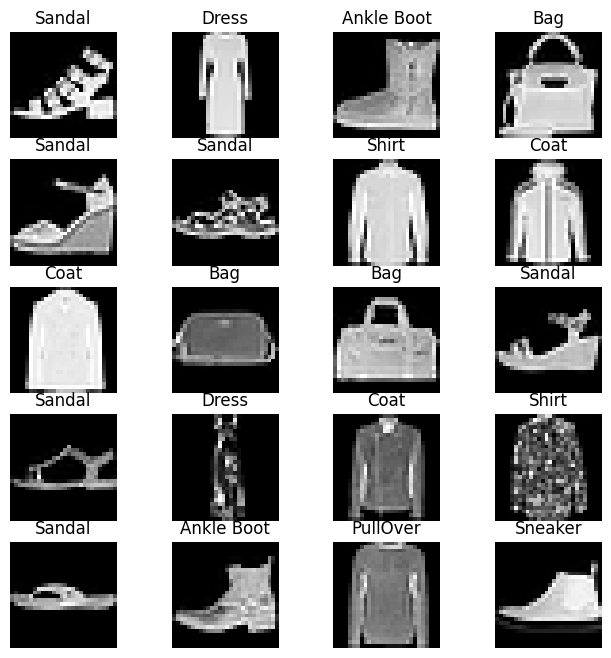

In [5]:
labels_map = {0:'T-shirt', 1:'Trouser', 2:'PullOver', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}



fig = plt.figure(figsize=(8,8));
columns=4;
rows = 5;

for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

plt.show()

- img_xy = np.random 부 : 무작위 데이터 생성 시 활용
  - np.random.randint() : 이산형 분포를 갖는 데이터에서 무작위 표본 추출시 사용  --> 0~train_dataset의 길이 값을 갖는 분포에서 랜덤한 숫자 하나를 생성하라는 의미   
  - random.rand, random.randn과 같은 다른 예시도 있음

- img = train_dataset~ 부분
: train_dataset을 활용한 3차원 배열을 생성함
해당 배열에서 랜덤하게 생성된 위치의 요소 값을 가져오겠다는 의미


In [6]:
## ConvNet 적용 X 버전

class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

- nn : Linear는 단순 선형 회귀 모델을 만들 때 사용함
  - 입력 크기와 출력 크기를 파라미터로 가짐

- torch.nn.Dropout(p) : p만큼의 비율로 텐서의 값이 0이 되고, 그렇지 않은 값들은 기존 값에 (1/(1-p))만큼 곱해진다.

- forward : 순전파 학습을 진행시키고, 이름은 꼭 **forward여야 함**
  - view : numpy의 reshape과 같은 역할임. 텐서의 **shape**을 변경해주는 역할
  - 활성화 함수 : F.relu()처럼 forward 함수에서 정의, nn.ReLU처럼 __init__ 함수에서 정의  

    - nn을 활용하는 경우 (nn.ReLU)
      : 입력을 랜덤으로 설정해주면, 가중치와 관련 내용은 모듈에서 처리
        - **nn.Sequential 안에 위치 가능**
    - nn.functional을 활용하는 경우 (F.relu)
      : 입력과 가중치 값을 모두 랜덤하게 설정해줘야 함
        - **nn.Sequential 안에 위치 불가능**


In [7]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count +=1


    if not (count%50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)


      accuracy = correct*100 /total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)


    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%".format(count, loss.data, accuracy))



Iteration : 500, Loss : 0.5496848821640015, Accuracy : 83.44999694824219%
Iteration : 1000, Loss : 0.48119255900382996, Accuracy : 84.69000244140625%
Iteration : 1500, Loss : 0.36760833859443665, Accuracy : 84.16000366210938%
Iteration : 2000, Loss : 0.3688809871673584, Accuracy : 85.16000366210938%
Iteration : 2500, Loss : 0.2529815435409546, Accuracy : 86.0999984741211%
Iteration : 3000, Loss : 0.27207183837890625, Accuracy : 86.70999908447266%


- train = Variable(images.view(100, 1, 28, 28))
: Autograd = 자동 미분을 수행하는 파이토치 패키지.
Variable을 활용해서 역전파를 위한 미분 값을 자동으로 계산해줌


- 분류 문제에서 클래스가 3개 이상일 때의 주의점
  - 정확도가 80% 이상이었을 때, 각 클래스의 개별 정확도가 80% 수준인 것인지, 아니면 **특정 클래스의 정확도가 유난히 높은 것인지** 확인해야 함
  - 전체 label의 클래스 분포를 고려해서 정확도를 관측해야 함. 불균형한 분포일 경우 단순 정확도로 성능을 판단할 수 없음



In [12]:
from torch.nn.modules.pooling import MaxPool2d
## 합성곱 신경망 구성

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)


  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

- nn.Sequential : 가독성이 좋고, 계층을 차례대로 쌓을 수 있도록 선형 변환식과 활성화 함수를 연결해주는 역할을 수행함.
계층을 하나의 컨테이너에 구현하는 방법.

- Convolution layer : 합성곱 연산을 통해 이미지의 특징을 추출.
커널을 이미지의 처음부터 끝까지 훑으면서 elementwise 연산을 수행하고 출력함.
  - in_channels : 입력 채널의 수. 흑백은 1, RGB는 3임
      - 여기서 말하는 channel은 **depth, 즉 깊이**를 의미한다고 생각하면 된다.
  - padding : 커널이 이미지를 훑으면 자연스럽게 이미지는 사이즈가 작아지게 된다. 이것을 막기 위해 수행하는 것이 padding임

- BatchNormal2d : 각 배치 단위의 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화 하는 것.

- MaxPool2d : 이미지의 크기를 축소시키는 용도로 사용함
  - 최대 풀링, 평균 풀링, 최소 풀링이 있으나 보통 최대 풀링을 활용한다.

- nn.Linear~ : 이미지 형태의 데이터를 배열 형태로 변환해 작업하는 것. 완전연결층으로 넘어가게 된다.

출력 크기 공식

- Conv2d 계층에서 출력 크기 = (W-F+2P)/S +1
  - W = 입력 데이터의 크기, F = 커널 크기, P = padding 크기, S = stride

- MaxPool2d 계층에서 출력 크기 = IF/F
  - IF = 입력 필터의 크기 (Conv2d의 출력 크기를 말함)
  - F = 커널 크기

In [13]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count +=1


    if not (count%50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)


      accuracy = correct*100 /total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)


    if not (count % 500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%".format(count, loss.data, accuracy))



Iteration : 500, Loss : 0.45942017436027527, Accuracy : 88.30999755859375%
Iteration : 1000, Loss : 0.33076420426368713, Accuracy : 88.30000305175781%
Iteration : 1500, Loss : 0.30128949880599976, Accuracy : 88.06999969482422%
Iteration : 2000, Loss : 0.2285914421081543, Accuracy : 89.25%
Iteration : 2500, Loss : 0.1968163549900055, Accuracy : 89.45999908447266%
Iteration : 3000, Loss : 0.1366589516401291, Accuracy : 90.44999694824219%
